<a href="https://colab.research.google.com/github/omkarsp644/Heart-Attack-And-Diabetes-prediction-using-python/blob/master/Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/Stock_Price_Prediction

/content/drive/My Drive/Stock_Price_Prediction


In [4]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import plotly.figure_factory as ff
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense


from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
df = pd.read_pickle('SIEMENS-15minute-Hist')
df = pd.DataFrame(df)
df['date'] = df['date'].apply(pd.to_datetime)
df.set_index('date',inplace=True)

In [6]:
fig = go.Figure(data=[go.Table(
    header=dict(values=list(['date','open','high','low','close','volume']),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[df.index,df.open, df.high, df.low, df.close,df.volume],
               fill_color='lavender',
               align='left'))
])

fig.show()

In [7]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.graph_objs import Line

fig = make_subplots(rows=4, cols=1,subplot_titles=('Open','High','Low','Close'))

fig.add_trace(
    Line(x=df.index, y=df.open),
    row=1, col=1
)

fig.add_trace(
    Line(x=df.index, y=df.high),
    row=2, col=1
)

fig.add_trace(
    Line(x=df.index, y=df.low),
    row=3, col=1
)

fig.add_trace(
    go.Line(x=df.index, y=df.close),
    row=4, col=1
)

fig.update_layout(height=1400, width=1000, title_text="OHLC Line Plots")

fig.show()

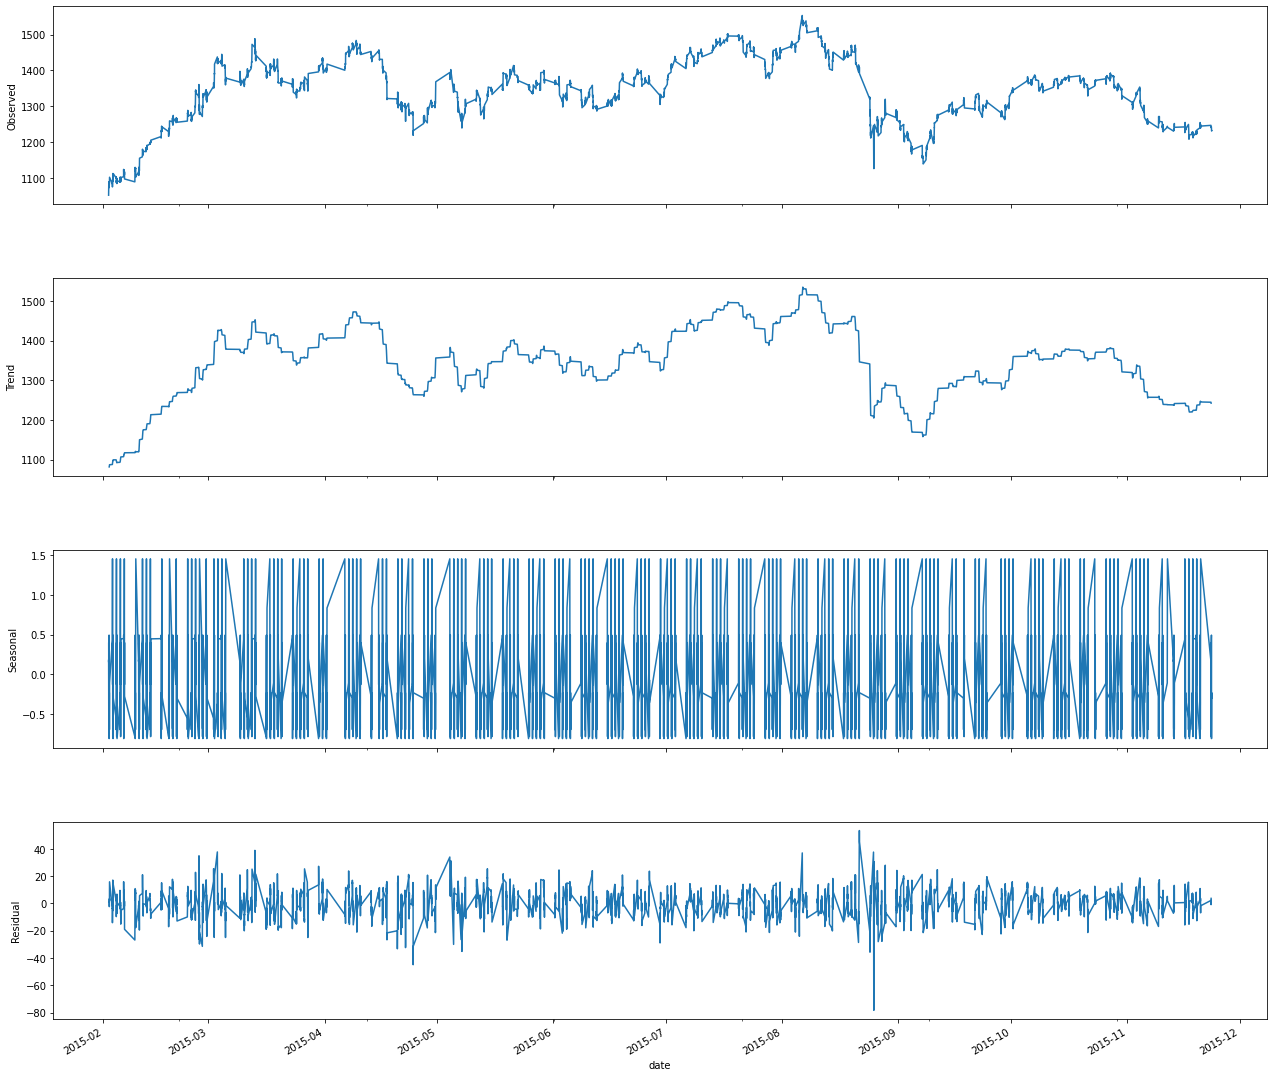

In [8]:
result = seasonal_decompose(df.close.head(5000), model='additive', freq = 30)
fig = go.Figure()  
fig = result.plot()  
fig.set_size_inches(20, 19)

In [9]:
''' Example candle stick code'''
open_data = [33.0, 33.3, 33.5, 33.0, 34.1]
high_data = [33.1, 33.3, 33.6, 33.2, 34.8]
low_data = [32.7, 32.7, 32.8, 32.6, 32.8]
close_data = [33.0, 32.9, 33.3, 33.1, 33.1]
dates = [datetime(year=2013, month=10, day=10),
         datetime(year=2013, month=11, day=10),
         datetime(year=2013, month=12, day=10),
         datetime(year=2014, month=1, day=10),
         datetime(year=2014, month=2, day=10)]

fig = go.Figure(data=[go.Candlestick(x=dates,
                       open=open_data, high=high_data,
                       low=low_data, close=close_data,
               increasing_line_color= 'green', decreasing_line_color= 'red')])

fig.show()


In [10]:
import plotly.graph_objects as go

import pandas as pd
from datetime import datetime


fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])])

fig.show()

In [11]:
new_df = pd.DataFrame()
new_df = df['close']
new_df.index = df.index

In [12]:
scaler=MinMaxScaler(feature_range=(0,1))
final_dataset=new_df.values

train_data=final_dataset[0:20000,]
valid_data=final_dataset[20000:,]

In [13]:
train_df = pd.DataFrame()
valid_df = pd.DataFrame()
train_df['Close'] = train_data
train_df.index = new_df[0:20000].index
valid_df['Close'] = valid_data
valid_df.index = new_df[20000:].index

In [14]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset.reshape(-1,1))

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [15]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

inputs_data=new_df[len(new_df)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

lstm_model.summary()

19940/19940 - 353s - loss: 2.9449e-04 - 353s/epoch - 18ms/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [16]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

In [17]:
valid_df['Predictions']=predicted_closing_price

In [18]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.index,y=train_df['Close'],
                    mode='lines',
                    name='Siemens Train Data'))
fig.add_trace(go.Scatter(x=valid_df.index,y=valid_df['Close'],
                    mode='lines',
                    name='Siemens Valid Data'))
fig.add_trace(go.Scatter(x=valid_df.index,y=valid_df['Predictions'],
                    mode='lines',
                    name='Prediction'))

In [19]:
from sklearn.metrics import mean_squared_error
print('The Mean Squared Error is',mean_squared_error(valid_df['Close'].values,valid_df['Predictions'].values))

The Mean Squared Error is 46.36953626399685


In [20]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=valid_df.index,y=valid_df['Close'],
                    mode='lines',
                    name='Test'))
fig.add_trace(go.Scatter(x=valid_df.index,y=valid_df['Predictions'],
                    mode='lines',
                    name='Predicted'))